In [29]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics
from ggplot import *

In [2]:
pairs = pd.read_csv('train.csv')

In [3]:
pairs.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
pairs.dtypes

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

In [5]:
pairs.describe()

,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614503,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [6]:
pairs.count()

id              404290
qid1            404290
qid2            404290
question1       404290
question2       404288
is_duplicate    404290
dtype: int64

In [3]:
pairs = pairs.dropna()

In [4]:
# get a dictionary of (qid, question) pairs
map1 = dict(zip(pairs['qid1'], pairs['question1']))
map2 = dict(zip(pairs['qid2'], pairs['question2']))

# merge dictionaries
id_text_map = {**map1, **map2}
corpus = {}
for k, v in id_text_map.items():
    corpus[k] = v
        
documents = list(corpus.values())
print(documents[:5])

['What is the step by step guide to invest in share market in india?', 'What is the story of Kohinoor (Koh-i-Noor) Diamond?', 'How can I increase the speed of my internet connection while using a VPN?', 'Why am I mentally very lonely? How can I solve it?', 'Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?']


In [31]:
vectorizer = TfidfVectorizer(sublinear_tf=True, ngram_range=(1, 3), norm='l2')
vec_model = vectorizer.fit(documents)

In [32]:
vec = vec_model.transform(['What is the step by step guide to invest in share market in india?'])
vec

<1x3858266 sparse matrix of type '<class 'numpy.float64'>'
	with 37 stored elements in Compressed Sparse Row format>

In [33]:
def tfidf_cosine_similarity(x, y, vec_model):
    """
    Compute tfidf vectors of strings x and y, compute cosine similarity
    :param x: 
    :type x: str 
    :param y:
    :type y: str
    :param vec_model:
    """
    x_vec = vec_model.transform([x])
    y_vec = vec_model.transform([y])
    
    cosine_sim = x_vec.dot(y_vec.transpose()).toarray()[0][0]
    
    return cosine_sim

In [34]:
x = 'What is the step by step guide to invest in share market in india?'
y = 'How can I increase the speed of my internet connection while using a VPN?'
tfidf_cosine_similarity(x, x, vec_model)
x_vec = vec_model.transform([x])
y_vec = vec_model.transform([y])
print(type(x_vec))
print(type(y_vec.transpose()))
x_vec.dot(y_vec.transpose()).toarray()[0][0]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csc.csc_matrix'>


0.0013645437081869585

In [9]:
pairs.shape

(404288, 6)

In [36]:
pairs['cos_sim'] = pairs.apply(lambda row: tfidf_cosine_similarity(row['question1'], row['question2'], vec_model), axis=1)

In [14]:
dupes = pairs[pairs['is_duplicate'] == 1][['is_duplicate', 'cos_sim']]
not_dupes = pairs[pairs['is_duplicate'] == 0][['is_duplicate', 'cos_sim']]

In [16]:
print(dupes['cos_sim'].describe())  # get values of similarity when duplicate
print(not_dupes['cos_sim'].describe())  # get values when not duplicate

count    149263.000000
mean          0.476332
std           0.280692
min           0.000000
25%           0.242166
50%           0.422517
75%           0.678054
max           1.000000
Name: cos_sim, dtype: float64
count    255025.000000
mean          0.270432
std           0.265653
min           0.000000
25%           0.059536
50%           0.178599
75%           0.429327
max           1.000000
Name: cos_sim, dtype: float64


0.72418311698


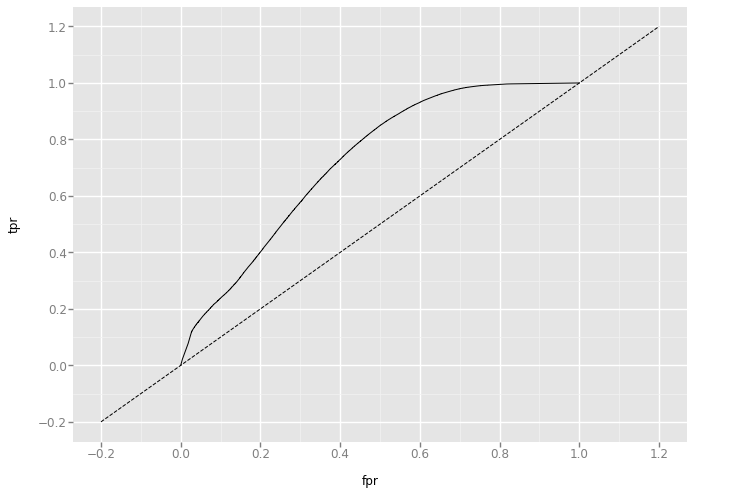

<ggplot: (301223856)>

In [30]:
fpr, tpr, _ = metrics.roc_curve(pairs['is_duplicate'], pairs['cos_sim'])
roc_df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
auc = metrics.auc(fpr,tpr)
print(auc)
ggplot(roc_df, aes(x='fpr', y='tpr')) + geom_line() + geom_abline(linetype='dashed')